# Config

**Import Library**
1. Imports the PyTorch library, which is provides core functionalities for tensor operations and deep learning.
2. The `nn` module contains classes and functions to build neural networks, including layers, loss functions, and activation functions.
3. The `torchvision` provides tools for image processing and computer vision tasks. It includes datasets, model architectures, and image transformations.
4. This `transforms` module from `torchvision` contains various image transformation functions that can be applied to datasets, such as resizing, normalization, and data augmentation.

In [223]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [224]:
if torch.cuda.is_available():
    print("GPU is available")
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU is not available, using CPU")

GPU is available
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [225]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyper-parameters

### Assistant
1. **sequence_length**: This parameter defines the length of the input sequences that the network will process. In a BRNN, the model needs to know how many time steps it should consider for each input sequence. For example, if you're working with time series data or sentences, this parameter determines how many time steps (or words) the model will look at in each input.

2. **input_size**: This represents the number of features in each time step of the input sequence. For instance, if you're working with images, this could be the number of pixels, or if you're working with text, it could be the size of the word embeddings. In a BRNN, each time step's input is fed into the network, and the input size determines how much information is provided at each step.

3. **hidden_size**: This parameter specifies the number of hidden units in the recurrent layers of the network. In a BRNN, there are typically two sets of hidden layers (one processing the sequence in the forward direction and the other in the backward direction). The hidden size determines the capacity of the model to learn complex patterns in the data.

4. **num_layers**: This indicates the number of stacked recurrent layers in the network. A BRNN can have multiple layers of recurrent units, allowing the model to learn hierarchical representations of the input data. More layers can help capture more complex patterns but may also increase the risk of overfitting.

5. **num_classes**: This parameter is relevant when the BRNN is used for classification tasks. It defines the number of output classes that the model will predict. For example, in a sentiment analysis task, this could be the number of sentiment categories (positive, negative, neutral).

6. **batch_size**: This defines the number of training examples used in one iteration of training. In the context of a BRNN, the batch size affects how the model learns from the data. A larger batch size can lead to more stable gradient estimates but may require more memory.

7. **num_epochs**: This parameter specifies how many times the entire training dataset will be passed through the network during training. In a BRNN, the number of epochs can influence how well the model learns the underlying patterns in the data. Too few epochs may lead to underfitting, while too many can lead to overfitting.

8. **learning_rate**: This is a critical hyperparameter that controls how much to change the model's weights with respect to the loss gradient during training. In a BRNN, an appropriate learning rate is essential for effective training. A learning rate that is too high can cause the model to converge too quickly to a suboptimal solution, while a learning rate that is too low can make the training process very slow.

In summary, these hyperparameters collectively define the architecture and training process of a Bidirectional Recurrent Neural Network, influencing its ability to learn from sequential data effectively. Adjusting these parameters can significantly impact the model's performance on tasks such as language modeling, time series prediction, and sequence classification.

In [228]:
# Define the length of the input sequence
sequence_length = 28

# Define the size of each input feature
input_size = 28

# Define the number of hidden units in the LSTM layer
hidden_size = 128

# Define the number of layers in the LSTM
num_layers = 2

# Define the number of output classes for classification
num_classes = 10

# Define the batch size for training
batch_size = 100

# Define the number of epochs for training
num_epochs = 2

# Define the learning rate for the optimizer
learning_rate = 0.003

# Load Dataset

1. **Loading the MNIST Dataset**:
   - `train_dataset = torchvision.datasets.MNIST(...)` - This line loads the MNIST training dataset. 
     - `train=True` indicates that this is the training dataset.
     - `transform=transforms.ToTensor()` converts the images to PyTorch tensors, which is necessary for processing in neural networks.
     - `download=True` allows the dataset to be downloaded if it is not already present in the specified directory.

2. **Creating Data Loaders**:
   - `train_loader = torch.utils.data.DataLoader(...)` - This line creates a data loader for the training dataset.
     - `dataset=train_dataset` specifies the dataset to load.
     - `batch_size=batch_size` sets the number of samples to be loaded in each batch (the variable `batch_size` should be defined elsewhere in the code).
     - `shuffle=True` randomizes the order of the data at every epoch, which helps improve model training.

   - `test_loader = torch.utils.data.DataLoader(...)` - This line creates a data loader for the test dataset.
     - `dataset=test_dataset` specifies the dataset to load.
     - `batch_size=batch_size` sets the number of samples per batch.
     - `shuffle=False` indicates that the test data should not be shuffled, maintaining the original order for evaluation.

Overall, this code snippet prepares the MNIST dataset for training and testing by loading the data and creating data loaders that facilitate batch processing.

In [231]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./Dataset_DL',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./Dataset_DL',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [232]:
# Print the size of the datasets
print("Size of the training dataset:", len(train_dataset))  # Number of training samples
print("Size of the test dataset:", len(test_dataset))      # Number of test samples

Size of the training dataset: 60000
Size of the test dataset: 10000


# Model

**Bidirectional recurrent neural network (many-to-one)**

In [235]:
# This line defines a new class `BiRNN` that inherits from `nn.Module`, which is a base class for all neural network modules in PyTorch.
class BiRNN(nn.Module):
    # Constructor Method
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # Super Constructor
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # This line creates an LSTM layer with the specified input size, hidden size, and number of layers.
        # The `batch_first=True` argument indicates that the input tensors will have the batch size as the first dimension.
        # The `bidirectional=True` allowing the LSTM to process the input sequence in both forward and backward directions.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # This line defines a fully connected (linear) layer that takes the output from the LSTM
        # and maps it to the number of output classes.
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x): # `x` is the input tensor
        # Set initial states to zero value
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        #  - `:` - The first colon selects all batches in the batch dimension.
        # - `-1` - The `-1` index selects the last time step in the sequence for each batch.
        # - `:` - The second colon selects all features in the hidden state dimension (which is `hidden_size*2`).
        out = self.fc(out[:, -1, :])
        return out

In [236]:
model = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss Function and optimizer
- `nn.CrossEntropyLoss()` It combines log softmax and negative log likelihood loss in one single function.
- `torch.optim.Adam`: This is an adaptive optimizer based on a combination of momentum and root mean square propagation (RMSprop). It adjusts the learning rate for each parameter individually, making it highly effective for complex models and tasks.
- `model.parameters()`: This passes all the parameters of the model to the optimizer, which will be updated during training.

**Alternatives**:
- Loss Function
  1. `nn.BCEWithLogitsLoss()`: Binary classification or multi-label classification where each label is independent. This is a combination of sigmoid activation and binary cross-entropy in one function. Use this when you don't apply a sigmoid in the model output.
  2. `nn.NLLLoss()`(Negative Log Likelihood Loss): Used for multi-class classification, similar to `CrossEntropyLoss`. Requires the model output to pass through a log-softmax activation function, i.e., the logits should be transformed into log-probabilities before applying NLLLoss. using `nn.LogSoftmax(dim=1)`.
  3. `nn.LabelSmoothingLoss`: Used to avoid overconfidence in classification by smoothing the hard labels, particularly in tasks where overfitting can happen easily. This loss function slightly relaxes the assumption that each sample belongs 100% to one class by distributing a small probability mass to the other classes.
- Optimizer
  1. `torch.optim.SGD` (Stochastic Gradient Descent): basic optimizers that updates parameters using the gradient of the loss function. It can be combined with momentum to speed up convergence.
  2. `torch.optim.RMSprop`: Useful for dealing with non-stationary objectives (like training recurrent networks). It divides the learning rate by a running average of the magnitudes of recent gradients.

In [239]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [250]:
import matplotlib.pyplot as plt

# Initialize a list to store the loss values for each iteration
loss_list = []

total_step = len(train_loader) # Total number of batches in the dataset
for epoch in range(num_epochs): 
    # images: The input data (e.g., images for computer vision tasks).
    for i, (images, labels) in enumerate(train_loader): # Loop over each batch in the data loader
        # The images tensor is reshaped to match the expected input dimensions of the model.
        # -1: This automatically infers the batch size, which can vary depending on how the data is loaded.
        images = images.reshape(-1, sequence_length, input_size).to(device) 
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images) # outputs, which are predictions for the input batch.
        loss = criterion(outputs, labels) # The loss is a measure of how far the model’s predictions are from the actual labels (SMALL GOOD)
        
        # Backward and optimize
        optimizer.zero_grad() # Resets the gradients for the next backward pass.
        loss.backward() # Computes the gradients of the loss function with respect to the model's parameters.
        optimizer.step() # Performs a single optimization step (parameter update) based on the computed gradients.

        if (i+1) % 50 == 0:
            loss_list.append(loss.item())
        
        # loss.item(): The current loss value, converted from a tensor to a scalar for easier display. 
        # The loss is printed with a precision of 4 decimal places.
        if (i+1) % 100 == 0:
            # Store the loss value for visualization
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item())) 

Epoch [1/2], Step [100/600], Loss: 0.9063
Epoch [1/2], Step [200/600], Loss: 0.6750
Epoch [1/2], Step [300/600], Loss: 0.4792
Epoch [1/2], Step [400/600], Loss: 0.2990
Epoch [1/2], Step [500/600], Loss: 0.2599
Epoch [1/2], Step [600/600], Loss: 0.1685
Epoch [2/2], Step [100/600], Loss: 0.3232
Epoch [2/2], Step [200/600], Loss: 0.1384
Epoch [2/2], Step [300/600], Loss: 0.2396
Epoch [2/2], Step [400/600], Loss: 0.1806
Epoch [2/2], Step [500/600], Loss: 0.1158
Epoch [2/2], Step [600/600], Loss: 0.0563


# Testing

In [251]:
with torch.no_grad(): # To disable gradient tracking and computation during inference
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images) # A forward pass for prediction
        # returns two values: The maximum value along dimension 1 (the class scores)
        # The index of the maximum value, which corresponds to the predicted class.
        # predicted: The index of the highest-scoring class is stored in the predicted variable.
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 96.55 %


# Result

**Visual Loss on Training**

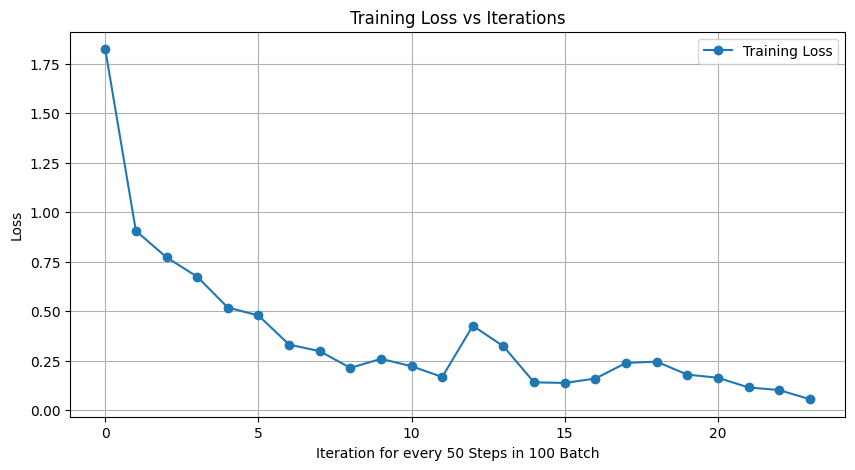

In [252]:
# After training, plot the loss curve
plt.figure(figsize=(10,5))
plt.plot(loss_list, label='Training Loss', marker='o')

# Annotate each point with its value
# for i, value in enumerate(loss_list):
#     plt.text(i, 
#         value, 
#         f'{value:.2f}', 
#         fontsize=12, 
#         ha='right'
#             ) 

plt.xlabel('Iteration for every 50 Steps in 100 Batch')
plt.ylabel('Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.grid(True)  # Optional
plt.show()

Save the model**

In [82]:
torch.save(model.state_dict(), r'.\Model\modelBi_RNN.ckpt')